In [1]:
import os
import string


DATA_DIR = 'D:/dev/datasets/NLP/areas_nlp_corpora_names'

# 所有可能的字符集合
ENG_LETTERS = string.ascii_letters + " .,;'-"
LETTER_COUNT = len(ENG_LETTERS) + 1     # 还需要考虑结束符EOS

CATEGORY_COUNT = 2

# 读取一个文件中的所有行
def read_lines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [line.strip() for line in some_file]

categories = ['male', 'female']
category_lines = {}
  
for category in categories:
    category_lines[category] = read_lines(os.path.join(DATA_DIR, f'{category}.txt'))[6:]

if len(category_lines) == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data to the directory.')

In [2]:
import torch


# 类别编码
def get_category_tensor(category):
    return torch.tensor([[0] if category[0] == 'm' else [1]])

# 对单个字符采取one_hot编码
def letter_to_index(letter):
    return ENG_LETTERS.find(letter)

# 定义名字中第一个到最后一个字母（不含EOF）为输入，并编码为one-hot向量
def get_input_tensor(line):
    size = len(line)
    res = torch.zeros(size, 1, LETTER_COUNT)
    for i in range(size):
        letter = line[i]
        res[i][0][letter_to_index(letter)] = 1
    return res

# 定义名字中第二个到最后一个字母加上EOF为输出，并编码为在ENG_LETTERS上的序号（EOF标记为LETTER_COUNT - 1）
def get_target_tensor(line: str):
    res = [letter_to_index(line[i]) for i in range(1, len(line))]
    res.append(LETTER_COUNT - 1)    # EOS
    return torch.LongTensor(res)

In [3]:
# 模型定义
from torch import nn


class My_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(My_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(1 + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(1 + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
import random


# 从数据集中随机采样一条数据及其类别
def random_training_example():
    category = random.choice(categories)
    line = random.choice(category_lines[category])
    category_tensor = get_category_tensor(category)
    input_line_tensor = get_input_tensor(line)
    target_line_tensor = get_target_tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [4]:
# 模型训练
model = My_RNN(LETTER_COUNT, 128, LETTER_COUNT)

criterion = nn.NLLLoss()
learning_rate = 3e-4

def train(category_tensor, input_line_tensor, target_line_tensor):    
    target_line_tensor.unsqueeze_(-1)
    hidden = model.init_hidden()

    model.zero_grad()

    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [6]:
import time
import math

# 用于打印训练时间
def timer(start):
    now = time.time()
    s = now - start
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:d}s'

In [12]:
iters_num = 100000
print_every = 5000      # 进度打印步进
plot_every = 500        # 平均损失记录步进
all_losses = []
average_loss = 0

start = time.time()

for it in range(1, iters_num + 1):
    _, loss = train(*random_training_example())
    average_loss += loss
    
    # 每隔5000次迭代输出一条进度消息
    if it % print_every == 0:
        print(f'{timer(start)} ({it} {(it / iters_num * 100):.1f}%) {loss:.4f}')
    
    # 每隔500次迭代记录一条平均损失
    if it % plot_every == 0:
        all_losses.append(average_loss / plot_every)
        average_loss = 0

0m 12.309578657150269s (5000 5.0%) 3.5156
0m 24.304199934005737s (10000 10.0%) 2.7305
0m 36.33287501335144s (15000 15.0%) 2.6762
0m 48.30807685852051s (20000 20.0%) 2.6743
1m 0.2724878787994385s (25000 25.0%) 2.5980
1m 12.314504146575928s (30000 30.0%) 2.5171
1m 24.31574535369873s (35000 35.0%) 2.7197
1m 36.250728368759155s (40000 40.0%) 2.2245
1m 48.28818988800049s (45000 45.0%) 2.6760
2m 0.2303166389465332s (50000 50.0%) 2.1399
2m 12.199409484863281s (55000 55.0%) 1.9734
2m 24.126017332077026s (60000 60.0%) 2.7420
2m 36.112340688705444s (65000 65.0%) 2.7475
2m 48.12141466140747s (70000 70.0%) 2.5350
3m 0.12208890914916992s (75000 75.0%) 2.5472
3m 12.061032772064209s (80000 80.0%) 2.2865
3m 24.919144868850708s (85000 85.0%) 2.8546
3m 37.01332187652588s (90000 90.0%) 3.3292
3m 48.99662113189697s (95000 95.0%) 2.5122
4m 1.0854244232177734s (100000 100.0%) 2.4303


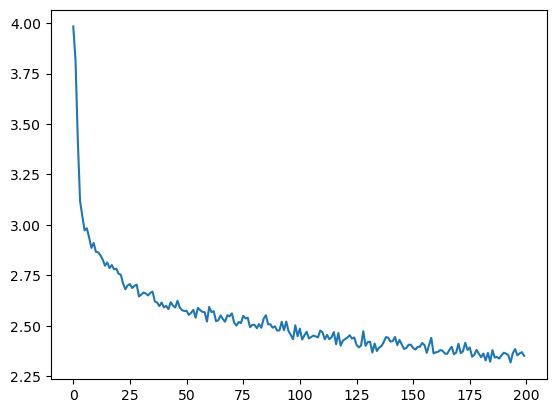

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [5]:
torch.save(model.state_dict(), 'name_generator_rnn.pth')

# 模型推理
model.load_state_dict(torch.load('name_generator_rnn.pth', weights_only=True))
model.eval()

My_RNN(
  (i2h): Linear(in_features=188, out_features=128, bias=True)
  (i2o): Linear(in_features=188, out_features=59, bias=True)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

In [22]:
# 由输出获取下一时刻出现概率最大的五个字符对应的索引及概率
def find_top_five_letters(output: torch.Tensor):
    output = output.flatten().tolist()
    indexed_output = list(enumerate(output))
    sorted_output = sorted(indexed_output, key=lambda x: x[1], reverse=True)
    top_five = sorted_output[:5]
    return top_five


from graphviz import Digraph

# 每一时刻前五个候选字符及对应概率的缓存；按照时刻（行）由先到后，概率（列）由高到低排列
top_five_cache = []

# 按索引从字符表中获取字符
def idx_ltr(idx: int):
    if idx < LETTER_COUNT - 1:
        return ENG_LETTERS[idx]
    else:
        return '[EOS]'

# 名字生成可视化图的构建和绘制
def plot_graph(filename, prefix='A'):
    g = Digraph(
    	format='png',
        engine='dot',
        node_attr={
            'shape': 'oval',
            'fontname': 'SimHei'
        },
        edge_attr={'arrowhead': 'normal'},
    )
    
    # 前缀部分的构建
    last = None     # 上一个前缀字符对应节点的标识
    pre_size = len(prefix)      # 前缀长度
    for i in range(pre_size):
        if last is not None:    # 边标签'X'表示是用户输入的前缀
            g.edge(last, prefix[i], label='X')
        for j in range(5):
            ltr = idx_ltr(top_five_cache[i][j][0])
            prob = top_five_cache[i][j][1]
            g.edge(prefix[i], ltr + f'({prob:.4f})', label='P')     # 'P'表示是模型推理出的可能字符；如果和'X'存在重叠，'P'的优先级更高
        last = prefix[i]
    
    # 找到前缀最后一个字符之后出现可能性最大的字符的信息
    ltr = idx_ltr(top_five_cache[pre_size - 1][0][0])
    prob = top_five_cache[pre_size - 1][0][1]
    last = ltr + f'({prob:.4f})'
    # 构建模型推理的字符相关信息
    for i in range(pre_size, len(top_five_cache)):
        for j in range(5):
            ltr = idx_ltr(top_five_cache[i][j][0])
            prob = top_five_cache[i][j][1]
            name = ltr + f'({prob:.4f})'
            if j == 0:  # 标记每一时刻可能性最大的字符，便于下一时刻的绘图
                lb = 'T'
                fir = name
            else:
                lb = 'P'
            g.edge(last, name, lb)
        last = fir
    g.render(filename, format='png', cleanup=True)
    g.view()
    del g
        
# 根据输入类别（男/女性）、前缀字符自动生成姓名
def predict(catagory, prefix='A'):
    with torch.no_grad():
        catagory_tensor = get_category_tensor(catagory)
        input_prefix_tensor = get_input_tensor(prefix)
        hidden = model.init_hidden()
        
        # 首先根据前缀（输入的字母）推算前缀各个字母输入后时刻的前5个候选字母
        for i in range(len(prefix)):
            output, hidden = model(catagory_tensor, input_prefix_tensor[i], hidden)
            top_five_cache.append(find_top_five_letters(output))
            
        # 找到前缀最后一位字母输入后的第一可能候选字母
        next_idx = top_five_cache[-1][0][0]
        res = []
        while next_idx != LETTER_COUNT - 1:
            next_letter = ENG_LETTERS[next_idx]
            res.append(next_letter)
            input_letter_tensor = get_input_tensor(next_letter)[0]
            output, hidden = model(catagory_tensor, input_letter_tensor, hidden)
            top_five = find_top_five_letters(output)
            top_five_cache.append(top_five)
            next_idx = top_five[0][0]
        
    plot_graph(catagory + '_' + prefix ,prefix)
    return prefix + ''.join(res)

# print(predict('male', 'T'))
# print(predict('female', 'No'))
# print(predict('male', 'No'))
# print(predict('male', 'Los'))
print(predict('female', 'Bel'))

Bellie


In [16]:
print(predict('female', 'T'))

Tarie
